# Raport
Autorzy: Staroń Kacper, Szypuła Jakub, Urbala Anna

## Zbiór danych
Wybraliśmy zbiór [cervical cancer](https://datahub.io/machine-learning/cervical-cancer) zawierający dane medyczne pacjentek, u części z nich zdiagnozowany został rak szyjki macicy. Całość składa się 835 rekordów. Kolumny:
- Age - wiek
- Number of sexual partners - liczba partnerów seksualnych
- First sexual intercourse - wiek inicjacji seksualnej
- Num of pregnancies - liczba ciąż
- Smokes - czy pali
- Smokes (years) - od ilu lat pali
- Smokes (packs/year) - liczba wypalanych paczek na rok
- Hormonal Contraceptives - czy stosuje antykoncepcję hormonalną
- Hormonal Contraceptives (years) - od ilu lat stosuje antykoncepcję hormonalną
- IUD - czy stosuje wkładkę domaciczną
- IUD (years) - od ilu lat stosuje wkładkę domaciczną
- STDs - czy ma/miała chorobę przenoszą drogą płciową
- STDs (number) - ile ma/miała chorób przenoszonych drogą płciową (kolejne kolumny zaczynające się od STDs oznaczają konkretne choroby)
- STDs:condylomatosis
- STDs:cervical condylomatosis
- STDs:vaginal condylomatosis
- STDs:vulvo-perineal condylomatosis
- STDs:syphilis
- STDs:pelvic inflammatory disease
- STDs:genital herpes
- STDs:molluscum contagiosum
- STDs:AIDS
- STDs:HIV
- STDs:Hepatitis B
- STDs:HPV
- STDs: Number of diagnosis
- STDs: Time since first diagnosis
- STDs: Time since last diagnosis
- Dx:Cancer - czy miała zdiagnozowanego raka
- Dx:CIN - czy miała zdiagnozowanego raka śródnabłonkowego
- Dx:HPV - czy były zakażona HPV
- Dx - czy była zdiagnozowane któreś z powyższych
Kolumny zmiennych celu (metoda diagnozy raka szyjki macicy):
- Hinselmann
- Schiller
- Citology
- Biopsy

Większość z tych kolumn zawiera braki danych ze względów osobistych pacjentek. 
### Zmienna celu
Celem zadania jest prognozowanie raka szyjki macicy na podstawie posiadanych danych.

W zbiorze wyjściowym są cztery kolumny celu, jednak postanowiliśmy ograniczyć się do jednej. Stworzyliśmy własną kolumnę celu, która jest sumą logiczną tamtych czterech. Nazwaliśmy ją *cancer*.

## Analiza zbioru

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

data = pd.read_csv('cervical-cancer_csv.csv')

In [10]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title='Automatyczny Raport Pandas Profiling', html={'style':{'full_width':True}})
profile.to_file(output_file="raportautomatyczny.html")

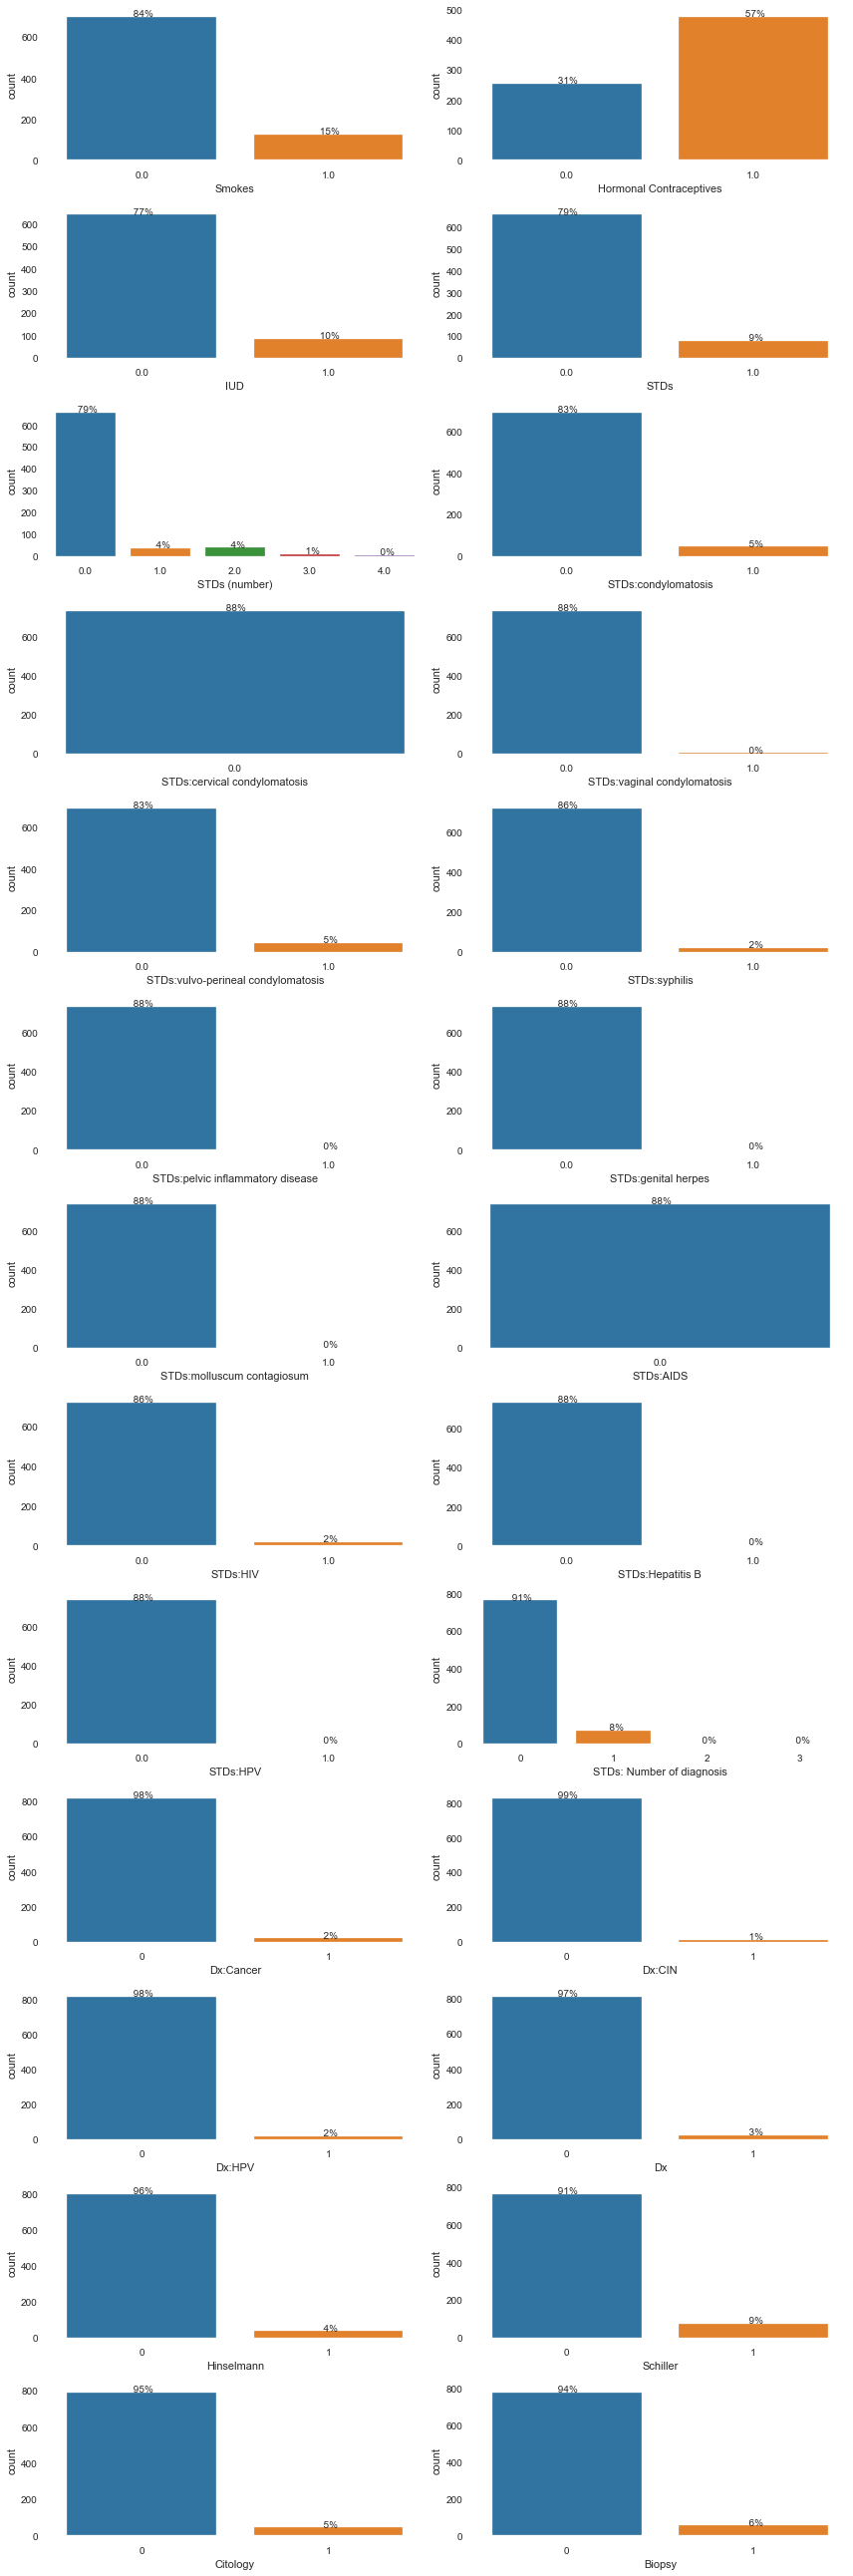

In [5]:
# Rozkład zmiennych kategorycznych
categorical = ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 
               'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
              'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum',
              'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
               'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']

fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(12, 36))
axes = axes.flatten()
total = len(data)
for idx, ax in enumerate(axes):
    plt.sca(ax)
    ax = sns.countplot(x = categorical[idx], data=data)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:3.0f}%'.format(100 * height/total),
            ha="center")
sns.despine()
plt.tight_layout()
plt.show()

### Problem braku danych
Ze względu na liczne braki danych podjęliśmy następujące decyzje:
- ze względu na (prawie) brak danych innych niż 0 usuwamy następujące kolumny:
    * STDs:cervical condylomatosis
    * STDs:vaginal condylomatosis
    * STDs:pelvic inflammatory disease
    * STDs:genital herpes
    * STDs:molluscum contagiosum
    * STDs:AIDS
    * STDs:Hepatitis B
    * STDs:HPV
    * Dx:CIN
- pozostałe kolumny kategoryczne: w związku z tym, że użyjemy OHE, tworzymy dodatkową kolumnę na brak danych
- dane ciągłe: będą normalizowane, więc ustawienie braków na 0 (czyli średnia) jest bezpieczne

### Wstępny szablon imputacji i obróbki danych

In [12]:
from sklearn.preprocessing import StandardScaler
dane = pd.read_csv('cervical-cancer_csv.csv')

# usuwanie kolumn
dane = dane.drop(['STDs:cervical condylomatosis', 
         'STDs:vaginal condylomatosis', 
         'STDs:pelvic inflammatory disease', 
         'STDs:genital herpes',
         'STDs:molluscum contagiosum',
         'STDs:AIDS',
         'STDs:Hepatitis B',
         'STDs:HPV', 'Dx:CIN'], axis=1)

# uzupełnianie braków i kodowanie zmiennych kategorycznych
def column_nodata(df, column_name):
    df[column_name + "_null"] = df[column_name].apply(lambda x: 1 if pd.isnull(x) else 0)
    df[column_name] = df[column_name].fillna(0)

def replace_in_column(df, column_name, src, dst):
    df[column_name] = df[column_name].replace(to_replace=src, value=dst)

replace_in_column(dane, 'STDs (number)', [3, 4], 2)
replace_in_column(dane, 'STDs: Number of diagnosis', [2,3], 1)

nodata_categories = [
    'Smokes',
    'Hormonal Contraceptives',
    'IUD',
    'STDs',
    'STDs (number)',
    'STDs:condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:HIV'
]

for category in nodata_categories:
    column_nodata(dane, category)
    
dane = pd.concat([dane, pd.get_dummies(dane['STDs (number)'], prefix='STDs_')],axis=1)
dane.drop(['STDs (number)'],axis=1, inplace=True)

# standaryzacja
numerical = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 
            'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs: Time since first diagnosis',
            'STDs: Time since last diagnosis']

scaler = StandardScaler() 
dane_scaled = scaler.fit_transform(dane[numerical])
d2 = pd.DataFrame(dane_scaled, columns = numerical)
dane[numerical] = d2[numerical]

# stworzenie jednego targetu
targets = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']
def has_cancer(row):
    for target in targets:
        if row[target] == 1:
            return 1
    return 0

dane['cancer'] = dane.apply(lambda row: has_cancer(row), axis=1)
dane = dane.drop(targets, axis=1)

## Podział zbioru i Miary

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# podzial zbioru na treningowy i testowy
def default_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=2137)

# scoring
def scoring(y_test, y_predicted):
    print("ACC = ", accuracy_score(y_test, y_predicted))
    print("PREC = ", precision_score(y_test, y_predicted))
    print("RECALL = ", recall_score(y_test, y_predicted))
    print("F1 = ", f1_score(y_test, y_predicted))
    print("AUC = ", roc_auc_score(y_test, y_predicted))

# wyodrebnienie y
def extract_y(data):
    y = data[["cancer"]]
    return data.drop(["cancer"], axis=1), y

Zbiór rozdzielamy na zbiór treningowy w rozmiarze 80% oryginalnego zbioru i testowy w rozmiarze 20% oryginalnego zbioru.
Stworzyliśmy funkcję, która zwraca wyniki pięciu różnych miar:
* accuracy, czyli $\frac{TP + TN}{FP + FN + TN + TP}$
* precision, czyli $\frac{TP}{TP+FP}$
* recall, czyli $\frac{TP}{TP+FN}$
* F1, czyli $\frac{2TP}{2TP+FP+FN}$
* AUC, czyli Area Under Curve

Gdzie:
* $TP$ - True Positive
* $TN$ - True Negative
* $FP$ - False Positive
* $FN$ - False Negative

W naszej ocenie najważniejsze było recall, ponieważ w badaniach raka ważne jest wykrycie choroby. Oczywiście, sama miara recall nie jest wystarczająca, dlatego braliśmy pod uwagę również pozostałe.

## Modele


In [18]:
# przygotowanie danych
X, y = extract_y(dane)
X = X.fillna(0)

X_train, X_test, y_train, y_test = default_split(X, y)

### Las losowy

In [19]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=50,
                                  max_depth=100,
                                  min_samples_split = 2,
                                  max_features = 7,
                                  random_state=0,
                                  n_jobs = -1)
model_rf.fit(X_train, y_train)
y_predicted_rf = model_rf.predict(X_test)
scoring(y_test, y_predicted_rf)

ACC =  0.8622754491017964
PREC =  0.5
RECALL =  0.08695652173913043
F1 =  0.14814814814814817
AUC =  0.5365338164251208


#### Strojenie

In [20]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 500, 800]
max_depth = [10, 25, 50, 75, 100]
min_samples_split = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 5] 
forest = RandomForestClassifier(random_state = 0)
hyperFrf = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridRF = GridSearchCV(forest, hyperFrf, cv = 5, verbose = 1, 
                      n_jobs = -1, scoring = 'average_precision')
bestRF = gridRF.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  5.7min finished


In [24]:
y_predicted_new_rf = bestRF.predict(X_test)
scoring(y_test, y_predicted_new_rf)

ACC =  0.8562874251497006
PREC =  0.0
RECALL =  0.0
F1 =  0.0
AUC =  0.4965277777777778


Jak widać, strojenie ręcznie zwróciło lepsze wyniki od strojenia za pomocą gridsearch

### GBM

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

model_gbm = GradientBoostingClassifier()
model_gbm.fit(X_train, y_train)
y_predicted_gbm = model_gbm.predict(X_test)
scoring(y_test, y_predicted_gbm)

ACC =  0.8502994011976048
PREC =  0.25
RECALL =  0.043478260869565216
F1 =  0.07407407407407408
AUC =  0.5113224637681159


#### Strojenie

In [23]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 500, 800]
max_depth = [1, 3, 5, 10]
min_samples_split = [2, 3, 5, 10]
learning_rate = [0.05, 0.1, 0.2] 
gbm = GradientBoostingClassifier()
hyperFGBM = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             learning_rate = learning_rate)

gridFGBM = GridSearchCV(gbm, hyperFGBM, cv = 5, verbose = 1, 
                      n_jobs = -1, scoring = 'average_precision')
bestFGBM = gridFGBM.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  2.6min finished


In [25]:
y_predicted_new_gbm = bestFGBM.predict(X_test)
scoring(y_test, y_predicted_new_gbm)

ACC =  0.8622754491017964
PREC =  0.5
RECALL =  0.043478260869565216
F1 =  0.08
AUC =  0.5182669082125604


### BogoModel

BogoModel jest autorskim modelem zaproponowanym przez nas, nazwanym po algorytmie sortowania `Bogosort`, który opiera się o losowanie. BogoModel uczy się, ile jest wystąpień 1 w zmiennej celu, następnie losuje 1, lub 0 w zmiennych testowych, z prawdopodobieństwem równym częstotliwości występowania 1 w zmiennej celu zbioru treningowego.

In [27]:
import copy
def BogoModelPredict(y_test):
    y_random_predicted = copy.copy(y_test)
    prob = y_train['cancer'].value_counts()[1]/y_train['cancer'].value_counts()[0]
    y_random_predicted['cancer'] = np.random.choice([0, 1], len(y_test), p=[1-prob, prob])
    return y_random_predicted

scoring(y_test, BogoModelPredict(y_test))

ACC =  0.7724550898203593
PREC =  0.058823529411764705
RECALL =  0.043478260869565216
F1 =  0.049999999999999996
AUC =  0.466183574879227


## Porównanie modeli
Zrobię jak wszystkie modele będą wrzucone - szypół

## Oświadczenie
Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł